This notebook is for prototyping subnetwork flow.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dataclasses
import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim
import transformer_lens.utils as tl_utils
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

from pii import utils
from pii.subnet_flow.masked_model import PerTokenMaskedTransformer

# torch.set_grad_enabled(False)

### Load models

In [3]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
with torch.no_grad():
    tl_model.generate("The capital of Germany is", max_new_tokens=20, temperature=0)

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
prompt = "The capital of Germany is"

mtf_test = PerTokenMaskedTransformer(tl_model, base_prompt=prompt)
print([n for n, p in mtf_test.named_parameters() if p.requires_grad])
with torch.no_grad():
    for name, mask in mtf_test.masks.items():
        if name == "31_mlp_out":
            print(name, mask.shape)
            continue
        mask *= 0

with torch.no_grad():
    print(
        mtf_test.tl_model.generate(
            "The capital of Germany is",
            max_new_tokens=20,
            temperature=0,
            use_past_kv_cache=False,  # This is important!
        )
    )
    mtf_test.masks_active = False
    print(
        mtf_test.tl_model.generate(
            "The capital of Germany is",
            max_new_tokens=20,
            temperature=0,
            use_past_kv_cache=False,  # This is important!
        )
    )

['masks.0_attn_out', 'masks.0_mlp_out', 'masks.1_attn_out', 'masks.1_mlp_out', 'masks.2_attn_out', 'masks.2_mlp_out', 'masks.3_attn_out', 'masks.3_mlp_out', 'masks.4_attn_out', 'masks.4_mlp_out', 'masks.5_attn_out', 'masks.5_mlp_out', 'masks.6_attn_out', 'masks.6_mlp_out', 'masks.7_attn_out', 'masks.7_mlp_out', 'masks.8_attn_out', 'masks.8_mlp_out', 'masks.9_attn_out', 'masks.9_mlp_out', 'masks.10_attn_out', 'masks.10_mlp_out', 'masks.11_attn_out', 'masks.11_mlp_out', 'masks.12_attn_out', 'masks.12_mlp_out', 'masks.13_attn_out', 'masks.13_mlp_out', 'masks.14_attn_out', 'masks.14_mlp_out', 'masks.15_attn_out', 'masks.15_mlp_out', 'masks.16_attn_out', 'masks.16_mlp_out', 'masks.17_attn_out', 'masks.17_mlp_out', 'masks.18_attn_out', 'masks.18_mlp_out', 'masks.19_attn_out', 'masks.19_mlp_out', 'masks.20_attn_out', 'masks.20_mlp_out', 'masks.21_attn_out', 'masks.21_mlp_out', 'masks.22_attn_out', 'masks.22_mlp_out', 'masks.23_attn_out', 'masks.23_mlp_out', 'masks.24_attn_out', 'masks.24_mlp_

  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is are The The of The The The The The The The The of The of The The The The The


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions


In [6]:
mtf_test.masks_active = True
with torch.no_grad():
    _, cache = mtf_test.tl_model.run_with_cache(
        prompt,
        remove_batch_dim=True,
    )

assert torch.allclose(cache["resid_pre", 2], cache["resid_post", 30])
assert not torch.allclose(cache["resid_pre", 2], cache["resid_post", 31])

### Perform optimization

In [26]:
def get_corr_prompt(question: str, correct: bool = True):
    return f"""\
[INST] <<SYS>>
You are an assistant who only responds with a single word. \
You only give {'correct' if correct else 'incorrect'} answers.
<</SYS>>

{question} [/INST] \
"""

question = "Nick Kyrgios, what sport does he play?"
prompt = get_corr_prompt(question, correct=True)
mtf = PerTokenMaskedTransformer(tl_model, base_prompt=prompt)

print(prompt)
utils.get_top_responses(
    prompt=prompt,
    model=mtf.tl_model,
    top_k=5,
    use_kv_cache=False,
)

correct_str = "Tennis"
correct_token = tl_model.to_tokens(correct_str)[0, 1].item()
print(correct_token)

[INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>

Nick Kyrgios, what sport does he play? [/INST] 
Rank 0. Logit: 26.75 Prob: 99.86% Tokens: (29010) |Tennis|</s>|
Rank 1. Logit: 19.81 Prob:  0.10% Tokens: (  323) |T|EN|N|IS|</s>|
Rank 2. Logit: 19.00 Prob:  0.04% Tokens: (22556) |tennis|</s>|
Rank 3. Logit: 15.33 Prob:  0.00% Tokens: (27884) |ATP|</s>|
Rank 4. Logit: 15.17 Prob:  0.00% Tokens: (  376) |"|T|ennis|"|</s>|
29010


In [27]:
prompt_tokens = tl_model.to_tokens(prompt)
optim = torch.optim.Adam(
    mtf.masks.parameters(),
    lr=1e-2,
)

alpha = 5000
n_steps = 400
clamp_every = 1000000000000
threshold = 0.05

metric_history: list[dict[str]] = []
pbar = tqdm(range(n_steps))
for i in pbar:
    logits = mtf.tl_model.forward(prompt_tokens, return_type="logits")[0]

    target_logit = logits[-1, correct_token]

    mask_sum = sum(mask.sum() for mask in mtf.masks.values())
    mask_numel = sum(mask.numel() for mask in mtf.masks.values())
    density = mask_sum / mask_numel
    scaled_density = density * alpha

    loss = -target_logit + scaled_density
    optim.zero_grad()
    loss.backward()
    optim.step()

    # Clamp the masks to be between 0 and 1
    with torch.no_grad():
        for mask in mtf.masks.values():
            mask.clamp_(0, 1)

    # Force the masks to be binary every `clamp_every` steps
    if i % clamp_every == 0 and i > 0:
        with torch.no_grad():
            for mask in mtf.masks.values():
                # mask[mask > threshold] = 1
                mask[mask <= threshold] = 0

    metrics = dict(
        step=i,
        loss=loss.item(),
        target_logit=target_logit.item(),
        mask_sum=mask_sum.item(),
        mask_numel=mask_numel,
        density=density.item(),
        scaled_density=scaled_density.item(),
    )
    metric_history.append(metrics)

    pbar.set_postfix(metrics)

  0%|          | 0/400 [00:00<?, ?it/s]

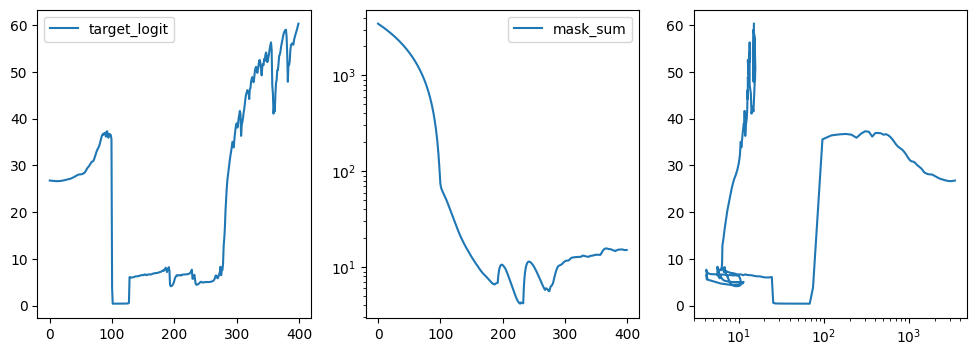

In [30]:
df = pd.DataFrame(metric_history)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
df.target_logit.plot()
plt.legend()

plt.subplot(1, 3, 2)
df.mask_sum.plot()
plt.yscale("log")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(df.mask_sum, df.target_logit)
plt.xscale("log")
plt.show()

In [31]:
print(prompt)
utils.get_top_responses(
    prompt=prompt,
    model=mtf.tl_model,
    top_k=5,
    use_kv_cache=False,
)

[INST] <<SYS>>
You are an assistant who only responds with a single word. You only give correct answers.
<</SYS>>

Nick Kyrgios, what sport does he play? [/INST] 
Rank 0. Logit: 60.68 Prob: 100.00% Tokens: (29010) |Tennis|/|the|/|the|/|
Rank 1. Logit: 38.44 Prob:  0.00% Tokens: (22556) |tennis|/|the|/|the|/|
Rank 2. Logit: 33.57 Prob:  0.00% Tokens: (16196) |textt|/|the|/|the|/|
Rank 3. Logit: 27.89 Prob:  0.00% Tokens: (    1) |<s>|nobody|/|the|/|the|
Rank 4. Logit: 27.78 Prob:  0.00% Tokens: (23217) |zvuky|/|the|/|the|/|


### Visualize remaining flow

691


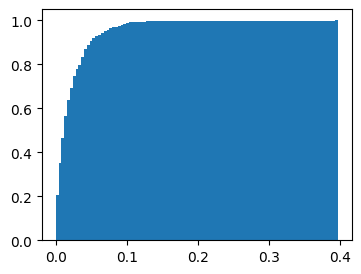

In [32]:
# Analysis of mask values
all_mask_values = (
    torch.cat([mask.flatten() for mask in mtf.masks.values()])
    .detach()
    .cpu()
    .numpy()
)

print((all_mask_values > 0).sum())

plt.figure(figsize=(4, 3))
plt.hist(
    all_mask_values[all_mask_values > 0],
    cumulative=True,
    bins=100,
    density=True,
)
plt.show()

# print(all_mask_values[all_mask_values > 0].min())
# print((all_mask_values > 0.1).sum())

In [16]:
for mask_name, mask in mtf.masks.items():
    if mask.max() > 0:
        print(mask_name, mask)

31_mlp_out Parameter containing:
tensor([0.0942, 0.4147, 0.5860, 1.0000, 0.3247, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.3663, 0.1953, 0.3562, 0.2087, 1.0000, 1.0000, 0.0383, 0.1584,
        1.0000, 0.2585, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7673, 1.0000,
        0.5516, 0.9551, 0.3667, 0.6268, 1.0000, 0.7908, 0.2764, 1.0000, 1.0000,
        0.6759, 0.7730, 0.3051, 1.0000, 0.5812, 0.7662, 1.0000, 0.0905, 0.9254,
        0.4492, 0.9582, 1.0000, 0.4468, 0.5667, 0.7800, 1.0000, 0.8419, 1.0000],
       device='cuda:0', requires_grad=True)


In [22]:
mtf.masks_active = True
with torch.no_grad():
    _, cache = mtf_test.tl_model.run_with_cache(
        prompt,
        remove_batch_dim=True,
    )

cache["resid_pre", 17] - cache["resid_pre", 18]

tensor([[-4.0979e-03, -1.0803e-03,  1.5299e-03,  ...,  2.8945e-03,
          8.2326e-03,  1.0146e-02],
        [-1.7113e-01,  5.6947e-02,  1.5653e-01,  ..., -8.7563e-02,
         -3.4393e-02,  2.6082e-02],
        [ 7.8579e-02, -2.2815e-02,  8.4024e-03,  ..., -1.0410e-01,
         -1.0437e-01, -7.9825e-02],
        ...,
        [ 2.4893e-01, -3.4185e-02,  3.8277e-01,  ...,  2.6806e-01,
         -3.5537e-01, -1.2575e-02],
        [ 1.2009e-01,  1.1120e-01, -3.6125e-02,  ...,  2.6990e-01,
         -3.7772e-01, -5.1210e-02],
        [ 3.4553e-01,  4.4763e-05,  3.4930e-01,  ...,  2.6855e-01,
         -4.2936e-01,  5.6756e-02]], device='cuda:0')